# Quick Tutorial

In [2]:
%pylab inline
import gct
from gct.metrics import GraphClusterMetrics, ClusterComparator, GraphMetrics, SNAPGraphMetrics

Populating the interactive namespace from numpy and matplotlib


## Generate a random graph

We are going to create an undirected unweighted random graph with LFR(Lancichinetti–Fortunato–Radicchi) algorithms

In [3]:
from gct.dataset import random_dataset

In [4]:
if gct.dataset.local_exists("get_start"):
    ds=gct.dataset.load_dataset("get_start")
else:
    # a named graph be persistent on disk, use overide option if needed. 
    ds=random_dataset.generate_undirected_unweighted_random_graph_LFR(name="get_start", \
                                           N=128, k=16, maxk=32, mu=0.2, minc=32)


In [5]:
#gct.remove_data("get_start") #the dataset can be removed

In [6]:
#show the meta data
ds.get_meta()

{'name': 'get_start',
 'weighted': False,
 'has_ground_truth': True,
 'directed': False,
 'is_edge_mirrored': False,
 'parq_edges': '/data/data/get_start/edges.parq',
 'parq_ground_truth': {'default': '/data/data/get_start/gt_default.parq'},
 'additional': {'genopts': {'seed': None,
   'C': None,
   'om': None,
   'on': None,
   'maxc': None,
   'minc': 32,
   't2': None,
   't1': None,
   'mu': 0.2,
   'maxk': 32,
   'k': 16,
   'N': 128,
   'name': 'LFR',
   'directed': False,
   'weighted': False}},
 'description': 'LFR random graph'}

In [9]:
ds.get_edges().head()

,src,dest
index,,
0,0,16
1,0,34
2,0,40
3,0,49
4,0,56


In [6]:
#show the graound truth. A graph may have multiple ground truth. Here it is default.
gt=ds.get_ground_truth()['default']
gt.value().head()

2019-11-05 19:14:34,678 - Clustering - INFO - reading/data/data/get_start/gt_default.parq
INFO:Clustering:reading/data/data/get_start/gt_default.parq


,node,cluster
index,,
0,0,6
1,1,5
2,2,5
3,3,4
4,4,1


In [7]:
#there are six clusters and  #node per cluster is shown
gt.value()['cluster'].value_counts()

3    27
1    27
4    26
5    19
6    17
2    12
Name: cluster, dtype: int64

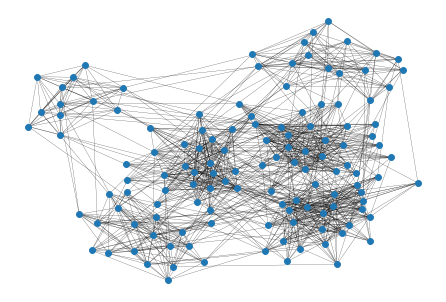

In [8]:
#networkx draws the graph showing that there are probably 6 clusters
import networkx as nx
nx.draw(ds.to_graph_networkx(), node_size= 35, width=0.2)

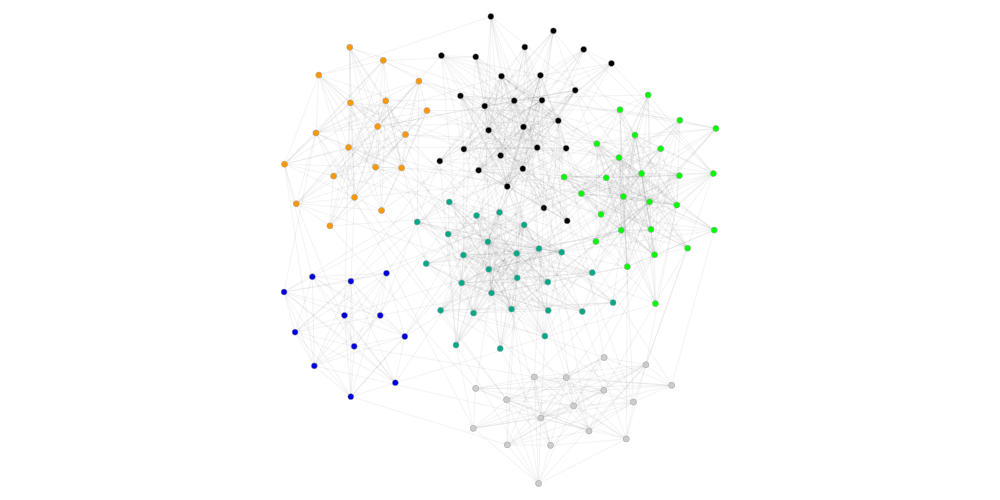

In [9]:
#for large graph, graph_tool is better at drawing. Here is wrapper function to use graph_tool drawing
GraphClusterMetrics(ds, gt).graph_tool_draw()

In [10]:
#We can show some basic graph properties using GraphMetrics and SNAPGraphMetrics class
gm=GraphMetrics(ds)
sgm=SNAPGraphMetrics(ds)
gm.density,gm.directed, gm.weighted,gm.num_edges, gm.num_vertices, sgm.average_clustering_coefficient(),sgm.diameter() 

2019-11-05 19:14:35,707 - Dataset:get_start - INFO - reading /data/data/get_start/edges.parq
INFO:Dataset:get_start:reading /data/data/get_start/edges.parq


(0.13213582677165353, False, False, 1074, 128, 0.4826466293236973, 4)

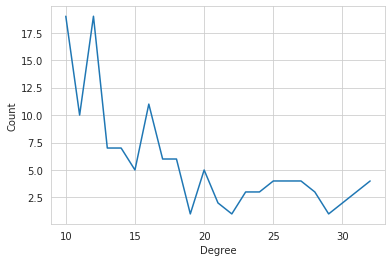

In [11]:
#show degree histogram
plt.plot(*(zip(*sgm.degree_histogram)))
plt.xlabel("Degree")
plt.ylabel("Count");

## Run Clustering Algorithms

In [12]:
#Show available algorithms
gct.list_algorithms()

['oslom_Infohiermap',
 'oslom_Infomap',
 'oslom_OSLOM',
 'oslom_copra',
 'oslom_louvain_method',
 'oslom_lpm',
 'oslom_modopt',
 'pycabem_GANXiSw',
 'pycabem_HiReCS',
 'pycabem_LabelRank',
 'cdc_CONGA',
 'cdc_CliquePercolation',
 'cdc_Connected_Iterative_Scan',
 'cdc_DEMON',
 'cdc_EAGLE',
 'cdc_FastCpm',
 'cdc_GCE',
 'cdc_HDEMON',
 'cdc_LinkCommunities',
 'cdc_MOSES',
 'cdc_MSCD_AFG',
 'cdc_MSCD_HSLSW',
 'cdc_MSCD_LFK',
 'cdc_MSCD_LFK2',
 'cdc_MSCD_RB',
 'cdc_MSCD_RN',
 'cdc_MSCD_SO',
 'cdc_MSCD_SOM',
 'cdc_ParCPM',
 'cdc_SVINET',
 'cdc_TopGC',
 'cdc_clique_modularity',
 'cgcc_CGGC',
 'dct_dlplm',
 'dct_dlslm',
 'dct_dlslm_map_eq',
 'dct_dlslm_no_contraction',
 'dct_dlslm_with_seq',
 'dct_infomap',
 'dct_seq_louvain',
 'igraph_community_edge_betweenness',
 'igraph_community_fastgreedy',
 'igraph_community_infomap',
 'igraph_community_label_propagation',
 'igraph_community_leading_eigenvector',
 'igraph_community_multilevel',
 'igraph_community_optimal_modularity',
 'igraph_community_sp

In [13]:
#get help on an algorithm
help(gct.alg_GossipMap)

Help on function alg_GossipMap in module gct.alg.function:

alg_GossipMap(name, graph, thresh=None, tol=None, maxiter=None, maxspiter=None, trials=None, interval=None, outmode=None, ncpus=None, scheduler=None, engine_opts=None, graph_opts=None, scheduler_opts=None, seed=None)
    A wrapper of *GossipMap* algorithm from https://github.com/uwescience/GossipMap. 
    
    Arguments
        GossipMap Algorithm:
        
        ================================ =======================================================
          --help                              Print this help message.
          --graph arg                         The graph file. Required.
          --format arg (=snap)                The graph file format.
          --thresh arg (=0.001)               The threshold for convergence condition.
          --tol arg (=1.00e-15)               The threshold for pagerank (ergodic 
                                              state) convergence condition.
          --maxiter arg (

We may specify a name when we run an algorithm, the run result of which will be persistent on disk and be loaded later. We run a simple lpa first.

In [14]:
def mean_dict(d):
    if isinstance(d,dict):
        return np.mean(list(d.values()))
    else:
        return d

In [15]:
lpa_cluster=gct.alg_pg_label_propagation("get_start_lpa", ds)

2019-11-05 19:14:35,992 - get_start_lpa - INFO - Running /opt/gct/submodules/PowerGraph/label_propagation --graph /tmp/tmpu2xjaf03/edges.txt --saveprefix=output.cluster --execution async --ncpus 7 --weighted 0 --directed 0
INFO:get_start_lpa:Running /opt/gct/submodules/PowerGraph/label_propagation --graph /tmp/tmpu2xjaf03/edges.txt --saveprefix=output.cluster --execution async --ncpus 7 --weighted 0 --directed 0
2019-11-05 19:14:36,483 - get_start_lpa - INFO - Made 5 clusters in 0.476943 seconds
INFO:get_start_lpa:Made 5 clusters in 0.476943 seconds


In [16]:
lpa_cluster

{'runname': 'get_start_lpa', 'params': {'execution': 'async', 'ncpus': 7, 'weighted': 0, 'directed': 0}, 'dataname': 'get_start', 'meta': {'lib': 'powergraph', 'name': 'label_propagation'}, 'timecost': 0.4769434928894043, 'clusters': {3: [105, 115, 73, 47, 3, 106, 120, 37, 71, 91, 107, 122, 108, 43, 58, 95, 40, 64, 112, 75, 12, 103, 90, 101, 111, 50], 5: [89, 4, 110, 124, 85, 126, 68, 63, 102, 100, 32, 14, 35, 26, 38, 67, 54, 56, 59, 113, 5, 99, 83, 125, 119, 80, 84, 98, 69, 116, 10, 114, 94, 87, 97, 121, 104, 46, 88, 66, 118, 127, 109, 123, 117, 7, 92, 57, 36, 17, 18, 74, 48, 79], 6: [0, 49, 76, 27, 16, 81, 6, 72, 22, 34, 60, 8, 20, 39, 42, 65, 52], 9: [21, 31, 13, 24, 41, 44, 9, 25, 55, 45, 28, 61], 19: [51, 86, 2, 53, 62, 93, 15, 11, 33, 78, 1, 77, 96, 19, 30, 23, 82, 70, 29]}}

6


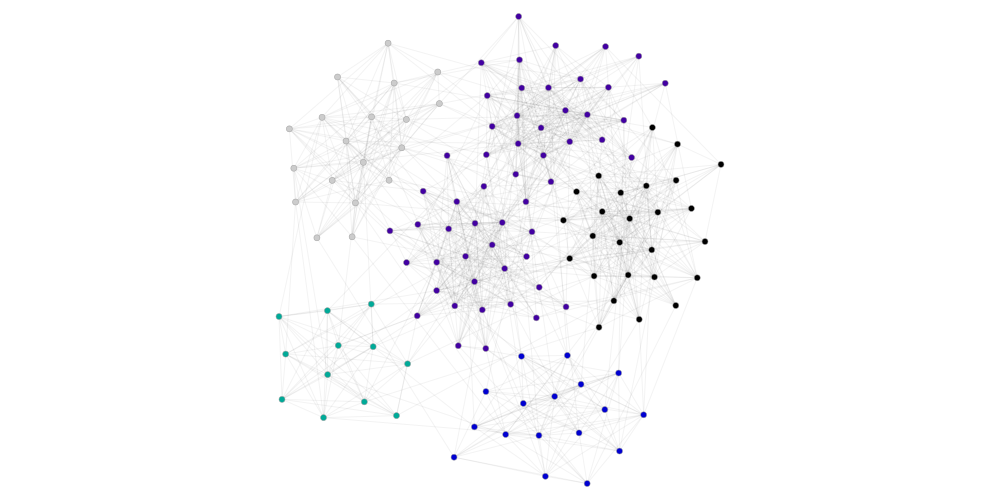

In [17]:
gcm=GraphClusterMetrics(ds, lpa_cluster)
print(gt.num_cluster)
gcm.graph_tool_draw()

In [18]:
#Let's look at some metrics for the clustering 
properties="conductance modularity separability cluster_expansions cluster_cut_ratios cluster_sum_intra_weights cluster_out_sum_weights cluster_clustering_coefficient  cluster_cut_ratios inter_cluster_density intra_cluster_density"
for p in properties.split():
    print ("{:40}= {:.5f}".format(p,  mean_dict(getattr(gcm,p))))

conductance                             = 0.18165
modularity                              = 0.52120
separability                            = 4.63914
cluster_expansions                      = 2.74368
cluster_cut_ratios                      = 0.02753
cluster_sum_intra_weights               = 358.40000
cluster_out_sum_weights                 = 71.20000
cluster_clustering_coefficient          = 0.67635
cluster_cut_ratios                      = 0.02753
inter_cluster_density                   = 0.02967
intra_cluster_density                   = 0.60920


In [19]:
# run another advanced algorithm
pscan_cluster=gct.scan_pScan("get_start_pscan", ds)

2019-11-05 19:14:36,917 - get_start_pscan - INFO - Running /opt/gct/submodules/ppSCAN/pscan /tmp/tmpdw1lnyil 0.5 3 output
INFO:get_start_pscan:Running /opt/gct/submodules/ppSCAN/pscan /tmp/tmpdw1lnyil 0.5 3 output
2019-11-05 19:14:36,935 - get_start_pscan - INFO - Made 6 clusters in 0.009383 seconds
INFO:get_start_pscan:Made 6 clusters in 0.009383 seconds


6


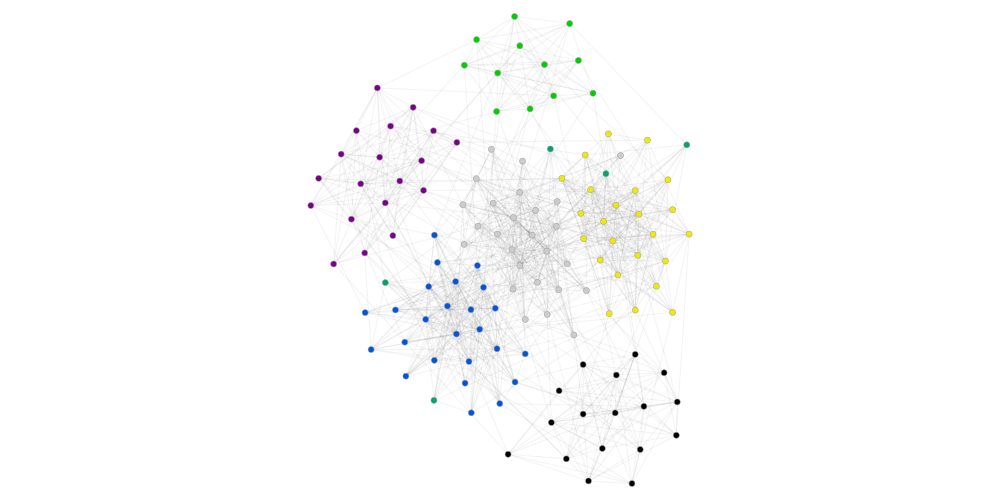

In [20]:
gcm=GraphClusterMetrics(ds, pscan_cluster)
print(gt.num_cluster)
gcm.graph_tool_draw()

In [21]:
#metrics for the clustering 
for p in properties.split():
    print ("{:40}= {:.5f}".format(p,  mean_dict(getattr(gcm,p))))

conductance                             = 0.21006
modularity                              = 0.57568
separability                            = 3.80297
cluster_expansions                      = 3.46932
cluster_cut_ratios                      = 0.03276
cluster_sum_intra_weights               = 273.00000
cluster_out_sum_weights                 = 76.00000
cluster_clustering_coefficient          = 0.70412
cluster_cut_ratios                      = 0.03276
inter_cluster_density                   = 0.03720
intra_cluster_density                   = 0.66965


In [22]:
#we can also take ground truth as clustering
gcm=GraphClusterMetrics(ds, gt)
print(gt.num_cluster)
#metrics for the clustering 
for p in properties.split():
    print ("{:40}= {:.5f}".format(p,  mean_dict(getattr(gcm,p))))

6
conductance                             = 0.19613
modularity                              = 0.60312
separability                            = 4.10291
cluster_expansions                      = 3.13825
cluster_cut_ratios                      = 0.02986
cluster_sum_intra_weights               = 287.00000
cluster_out_sum_weights                 = 71.00000
cluster_clustering_coefficient          = 0.69001
cluster_cut_ratios                      = 0.02986
inter_cluster_density                   = 0.03166
intra_cluster_density                   = 0.65088


In [23]:
#compare clustering with ground truth
cc = ClusterComparator(gt,lpa_cluster)
cc.sklean_nmi(),cc.xmeasure_nmi(all=True), cc.xmeasure(f1='a', omega=True)[0]

2019-11-05 19:14:37,345 - ClusterComparator - INFO - resulting 128 nodes out of 128,128
INFO:ClusterComparator:resulting 128 nodes out of 128,128
/opt/conda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
2019-11-05 19:14:37,361 - ClusterComparator - INFO - Running /opt/gct/submodules/xmeasures/xmeasures --all --nmi /tmp/tmplmlbh6dc/cluster1.cnl /tmp/tmplmlbh6dc/cluster2.cnl > xmeasurenmioutput
INFO:ClusterComparator:Running /opt/gct/submodules/xmeasures/xmeasures --all --nmi /tmp/tmplmlbh6dc/cluster1.cnl /tmp/tmplmlbh6dc/cluster2.cnl > xmeasurenmioutput
2019-11-05 19:14:37,385 - ClusterComparator - INFO - Running /opt/gct/submodules/xmeasures/xmeasures --f1=a --omega /tmp/tmpbbmnm090/cluster1.cnl /tmp/tmpbbmnm090/cluster2.cnl > xmeasureoutput
INFO:ClusterComparator:Running /

(0.912816686922137,
 {'NMI_max': 0.833234,
  'NMI_sqrt': 0.912817,
  'NMI_avg': 0.909032,
  'NMI_min': 1.0},
 {'MF1a_w': 0.859375, 'OI:': 0.739232})

In [24]:
#compare clustering with ground truth
cc = ClusterComparator(gt,pscan_cluster)
cc.sklean_nmi(),cc.xmeasure_nmi(all=True), cc.xmeasure(f1='a', omega=True)[0]

2019-11-05 19:14:37,408 - ClusterComparator - INFO - resulting 123 nodes out of 128,123
INFO:ClusterComparator:resulting 123 nodes out of 128,123
/opt/conda/envs/python3/lib/python3.6/site-packages/sklearn/metrics/cluster/supervised.py:859: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)
2019-11-05 19:14:37,422 - ClusterComparator - INFO - Running /opt/gct/submodules/xmeasures/xmeasures --all --nmi /tmp/tmpe7i8lpxr/cluster1.cnl /tmp/tmpe7i8lpxr/cluster2.cnl > xmeasurenmioutput
INFO:ClusterComparator:Running /opt/gct/submodules/xmeasures/xmeasures --all --nmi /tmp/tmpe7i8lpxr/cluster1.cnl /tmp/tmpe7i8lpxr/cluster2.cnl > xmeasurenmioutput
2019-11-05 19:14:37,442 - ClusterComparator - INFO - Running /opt/gct/submodules/xmeasures/xmeasures --f1=a --omega /tmp/tmpno9gieoh/cluster1.cnl /tmp/tmpno9gieoh/cluster2.cnl > xmeasureoutput
INFO:ClusterComparator:Running /

(1.0,
 {'NMI_max': 1.0, 'NMI_sqrt': 1.0, 'NMI_avg': 1.0, 'NMI_min': 1.0},
 {'MF1a_w': 1.0, 'OI:': 1.0})